In [38]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from wordcloud import WordCloud

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import download


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import random

In [30]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


# A. Business Understanding

## 1. Memahami Struktur Dataset
Langkah pertama adalah memahami struktur dataset.

In [43]:
df = pd.read_csv("all-data.csv",delimiter =',', encoding = 'latin-1', names = ['Sentiment','Document'] )

In [44]:
df

,Sentiment,Document
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [45]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  4846 non-null   object
 1   Document   4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB
None


In [46]:
print(df['Sentiment'].value_counts())

Sentiment
neutral     2879
positive    1363
negative     604
Name: count, dtype: int64


### Tujuan :
1. Melihat beberapa baris pertama dari data.
2. Memeriksa jeenis data pada setiap kolom.
3. Melihat distribusi sentimen(misalnya, "positive", "negative", "neutral")

## 2. Visualisasi Distribusi Sentimen
Melihat distribusi kelas sentimen.

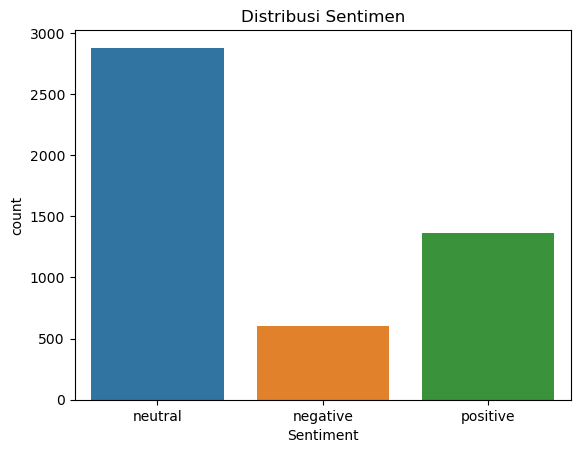

In [48]:
sns.countplot(x = "Sentiment", data=df)
plt.title('Distribusi Sentimen')
plt.show()

### Tujuan :
1. Memahami apakah dataset seimbang atau tidak (apakah ada kelas bias)

## 3. Analisis Panjang Dokumen
Menganalisis panjang teks dalam setiap dokumen.

count    4846.000000
mean       23.101114
std         9.958474
min         2.000000
25%        16.000000
50%        21.000000
75%        29.000000
max        81.000000
Name: doc_length, dtype: float64


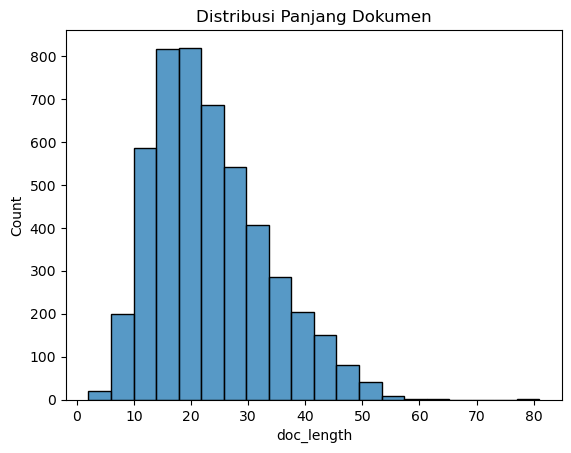

In [49]:
# Menambah kolom baru untuk menyimpan panjang tiap dokumen
df['doc_length'] = df['Document'].apply(lambda x: len(x.split()))

#statisik dasar dari panjang dokumen
print(df['doc_length'].describe())

# Visualisasi distribusi panjang dokumen

sns.histplot(df['doc_length'], bins= 20)
plt. title ('Distribusi Panjang Dokumen')
plt. show()

### Tujuan dari kode yang diberikan adalah:

1. Menambah Kolom doc_length: Menyimpan panjang setiap dokumen dalam jumlah kata untuk analisis lebih lanjut.

2. Statistik Dasar: Memberikan ringkasan statistik dari panjang dokumen (rata-rata, deviasi standar, minimum, maksimum) untuk memahami distribusi.

3. Visualisasi Distribusi: Menggunakan histogram untuk menunjukkan frekuensi panjang dokumen, memberikan gambaran visual tentang distribusi panjang dokumen dalam dataset.

Secara keseluruhan, langkah-langkah ini membantu memahami karakteristik dataset yang relevan untuk analisis sentimen atau model yang akan dikembangkan.

# B. Data Preparation

## 1. Mengatasi Missing Values
Selanjutnya, kita periksa apakah ada nilai yang hilang.

In [47]:
print(df.isnull().sum())

Sentiment    0
Document     0
dtype: int64


Tidak ada missing data jadi tidak diperlukan proses penghapusan baris dengan nilai yang hilang.

## 2.Memeriksa Baris Kosong:

Menghitung jumlah nilai null (kosong) dalam kolom Document menggunakan isnull().sum(). Ini membantu mengidentifikasi apakah ada dokumen yang hilang dalam dataset.

In [64]:
print(df['Document'].isnull().sum())  # Memeriksa baris kosong


0
0


## 3.Memeriksa Baris yang Hanya Berisi Spasi:

Menggunakan apply() untuk mengevaluasi setiap elemen di kolom Document. Dengan strip(), spasi di awal dan akhir string dihilangkan. Jika panjang string yang tersisa adalah 0, berarti baris tersebut hanya berisi spasi. Kode ini menghitung jumlah baris yang memenuhi kriteria tersebut.

In [ ]:
print(df['Document'].apply(lambda x: len(str(x).strip()) == 0).sum())  # Memeriksa baris yang hanya berisi spasi

## 4.Menghapus Baris Tidak Valid:

Menghapus semua baris yang memiliki teks kosong atau hanya berisi spasi dari DataFrame df. Ini dilakukan dengan membuat DataFrame baru yang hanya menyertakan baris di mana panjang teks setelah dihilangkan spasi lebih dari 0. Dengan langkah ini, dataset menjadi lebih bersih dan siap untuk analisis atau pemodelan lebih lanjut.

In [51]:
# Menghapus baris dengan teks kosong atau hanya spasi
df = df[df['Document'].apply(lambda x: len(str(x).strip()) > 0)]

## 5. Tahapan Preprocessing Teks:
### 1. Pengubahan Huruf Kecil:

 Teks diubah menjadi huruf kecil untuk menghindari perbedaan antara huruf besar dan kecil, sehingga konsistensi dalam analisis dapat terjaga.
### 2. Penghapusan Tanda Baca, Angka, dan Karakter Spesial:

 Menggunakan regular expressions (regex), semua karakter yang bukan huruf dan spasi dihapus. Ini membantu membersihkan teks dari elemen yang tidak relevan.
### 3. Tokenisasi:

Teks dibagi menjadi kata-kata (token) menggunakan fungsi word_tokenize. Ini adalah langkah penting sebelum melakukan analisis lebih lanjut.
### 4. Penghapusan Stopwords:

Stopwords, yaitu kata-kata umum seperti "the", "is", "and", yang tidak membawa makna signifikan, dihapus dari daftar token. Ini membantu fokus pada kata-kata yang lebih berarti dalam konteks analisis.
### 5. Lematisasi:

Setiap token diproses melalui lemmatizer untuk mengubah kata-kata ke bentuk dasarnya. Lematisasi berbeda dari stemming karena menghasilkan kata yang lebih tepat dan dapat dikenali dalam konteks bahasa.
### 6. Penggabungan Kembali Token:

Setelah pemrosesan, token yang sudah dibersihkan digabungkan kembali menjadi kalimat untuk disimpan dalam kolom baru cleaned_Document.

In [53]:
# Preprocessing function
def preprocess_text(text):
    # Mengubah teks menjadi huruf kecil
    text = text.lower()
    
    # Menghapus tanda baca, angka, dan karakter spesial
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenisasi
    tokens = word_tokenize(text)
    
    # Menghapus stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization (atau bisa gunakan stemming)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Menggabungkan kembali token menjadi kalimat
    return ' '.join(tokens)

# Terapkan preprocessing ke kolom Document
df['cleaned_Document'] = df['Document'].apply(preprocess_text)

# Menampilkan beberapa data setelah preprocessing
print(df[['Document', 'cleaned_Document']].head())

                                            Document  \
0  According to Gran , the company has no plans t...   
1  Technopolis plans to develop in stages an area...   
2  The international electronic industry company ...   
3  With the new production plant the company woul...   
4  According to the company 's updated strategy f...   

                                    cleaned_Document  
0  according gran company plan move production ru...  
1  technopolis plan develop stage area le square ...  
2  international electronic industry company elco...  
3  new production plant company would increase ca...  
4  according company updated strategy year baswar...  


### Hasil:
Dengan menerapkan tahapan ini, kolom cleaned_Document pada DataFrame df berisi teks yang telah dibersihkan dan siap untuk analisis lebih lanjut, seperti pelatihan model machine learning. Contoh data sebelum dan sesudah preprocessing ditampilkan untuk validasi.

### 6. Word Cloud
#### Deskripsi:
Word cloud adalah representasi visual dari kata-kata dalam suatu teks, di mana ukuran kata menunjukkan frekuensi atau kepentingannya dalam teks tersebut. Kata-kata yang lebih besar muncul lebih sering.
#### Tujuan: 
Visualisasi ini memberikan gambaran intuitif mengenai kata-kata kunci yang paling sering muncul dalam masing-masing kategori sentimen (positif, negatif, netral). Dengan melihat word cloud, kita bisa dengan cepat memahami tema utama yang muncul dalam dokumen berdasarkan sentimen tertentu.
#### Interpretasi: 
Jika kata-kata positif seperti "good," "great," atau "excellent" lebih besar dalam word cloud untuk sentimen positif, itu menunjukkan bahwa dokumen-dokumen tersebut mengandung banyak ungkapan positif. Sebaliknya, kata-kata negatif seperti "bad," "poor," atau "terrible" lebih menonjol pada sentimen negatif.

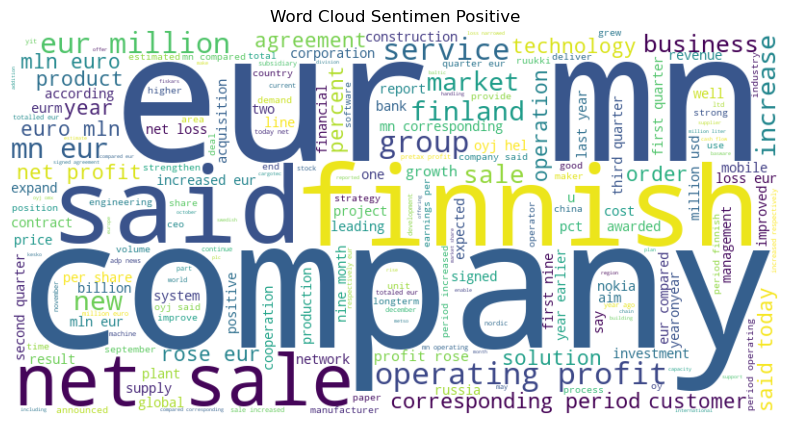

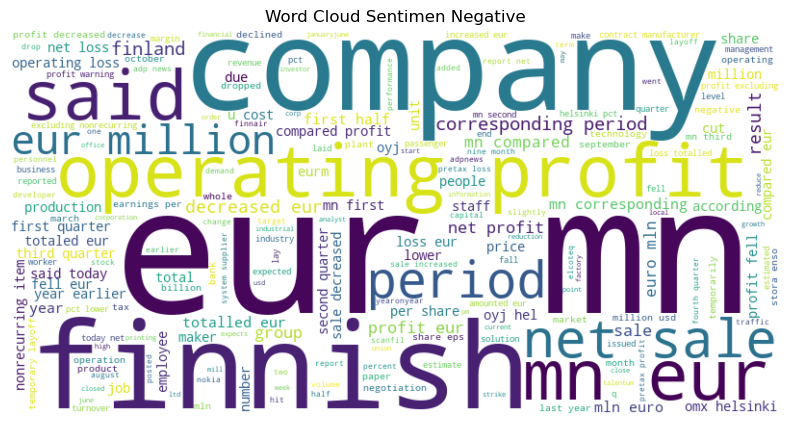

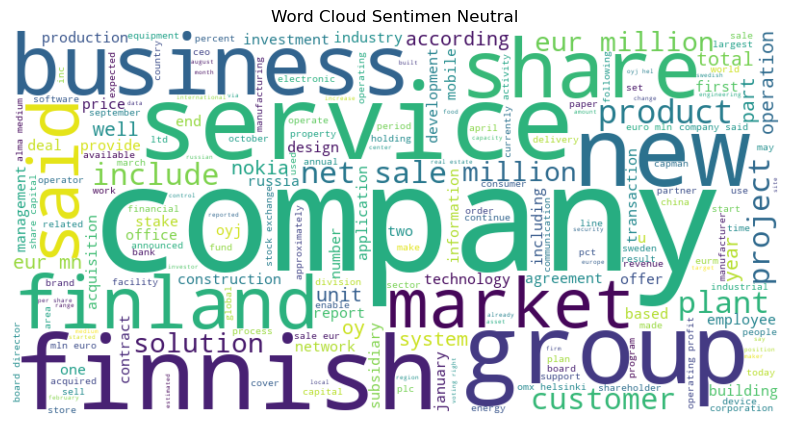

In [54]:
from wordcloud import WordCloud

# List sentimen
sentiments = ['positive', 'negative', 'neutral']

# Loop untuk menghasilkan word cloud untuk setiap sentimen
for sentiment in sentiments:
    text = " ".join(doc for doc in df[df['Sentiment'] == sentiment]['cleaned_Document'] if len(str(doc).strip()) > 0)
    
    if len(text) > 0:
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud Sentimen {sentiment.capitalize()}')
        plt.show()
    else:
        print(f'Tidak ada teks untuk sentimen {sentiment}')

### 7. 10 Kata yang Paling Sering Muncul
#### Deskripsi: 
Visualisasi ini menggunakan barplot untuk menunjukkan 10 kata yang paling sering muncul dalam seluruh dataset. Kata-kata tersebut dihitung menggunakan Counter dari modul collections.
#### Tujuan: 
Untuk memberikan wawasan lebih lanjut tentang kata-kata yang mendominasi keseluruhan teks, tanpa mempertimbangkan kategori sentimen. Ini membantu dalam memahami konteks umum dari data yang dianalisis.
#### Interpretasi: 
Dengan melihat kata-kata ini, kita dapat mengetahui istilah-istilah umum yang sering digunakan dalam dokumen. Misalnya, jika kata "service" muncul paling banyak, itu dapat menunjukkan fokus pada tema layanan dalam dataset.

10 kata yang paling sering muncul: [('eur', 1310), ('company', 971), ('mn', 593), ('said', 544), ('finnish', 512), ('sale', 501), ('million', 442), ('share', 435), ('profit', 413), ('net', 412)]


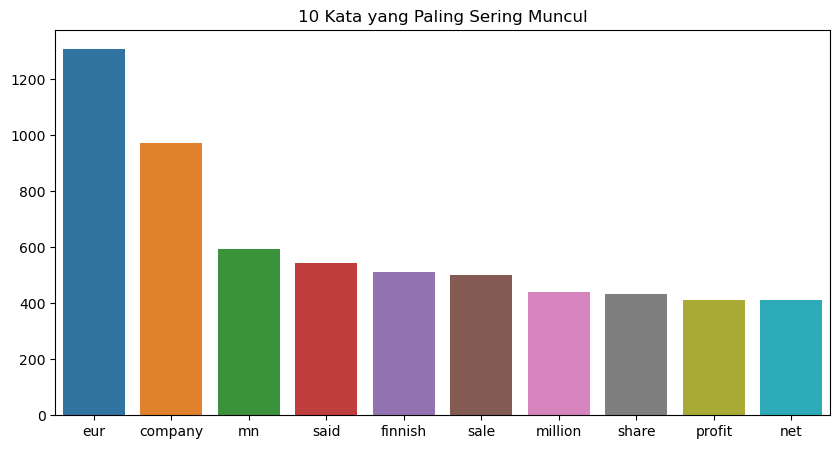

In [16]:
from collections import Counter

# Menggabungkan semua dokumen
all_words = " ".join(df['cleaned_Document'].tolist()).split()

# Menghitung frekuensi kata
word_freq = Counter(all_words)

# Menampilkan 10 kata yang paling sering muncul
common_words = word_freq.most_common(10)
print("10 kata yang paling sering muncul:", common_words)

# Plot frekuensi kata
words, counts = zip(*common_words)
plt.figure(figsize=(10,5))
sns.barplot(x=list(words), y=list(counts))
plt.title('10 Kata yang Paling Sering Muncul')
plt.show()

### 8. Boxplot Panjang Dokumen Berdasarkan Sentimen
#### Deskripsi: 
Boxplot ini menunjukkan distribusi panjang dokumen (dalam jumlah kata) berdasarkan kategori sentimen (positif, negatif, netral). Boxplot menampilkan median, kuartil, dan outlier dari panjang dokumen.
#### Tujuan: 
Untuk membandingkan panjang dokumen yang berbeda berdasarkan sentimen, memberikan informasi tentang variabilitas dan kecenderungan sentimen tertentu.
#### Interpretasi:
- Jika boxplot untuk sentimen positif menunjukkan panjang dokumen yang lebih tinggi dibandingkan dengan yang negatif atau netral, itu mungkin menunjukkan bahwa dokumen positif lebih mendalam atau lebih panjang.
- Outlier dapat menunjukkan dokumen yang sangat panjang atau pendek, yang mungkin perlu dianalisis lebih lanjut untuk memahami alasan di balik ketidakteraturan tersebut.

In [65]:
# Membuat kolom panjang dokumen (dalam jumlah kata)
df['document_length'] = df['cleaned_Document'].apply(lambda x: len(x.split()))

# Cek beberapa baris pertama untuk memastikan kolom berhasil terbuat
df[['cleaned_Document', 'document_length']].head()


,cleaned_Document,document_length
0,according gran company plan move production ru...,10
1,technopolis plan develop stage area le square ...,17
2,international electronic industry company elco...,21
3,new production plant company would increase ca...,20
4,according company updated strategy year baswar...,17


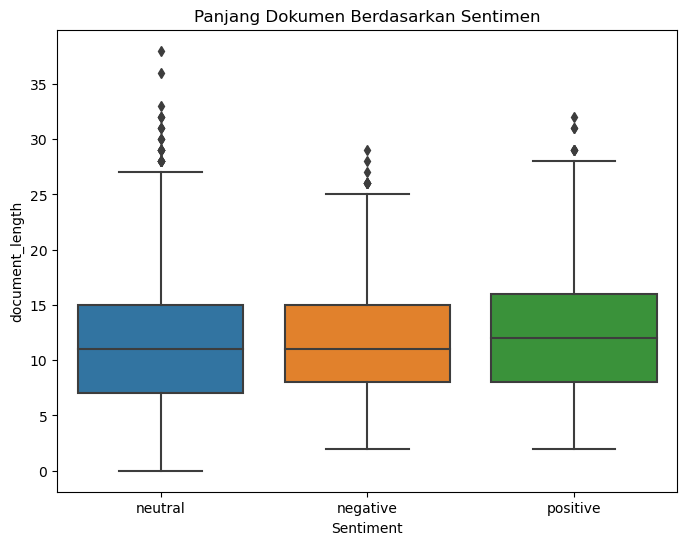

Sentiment
negative    11.849338
neutral     11.645363
positive    12.864270
Name: document_length, dtype: float64


In [56]:
# Plot boxplot panjang dokumen berdasarkan sentimen
plt.figure(figsize=(8,6))
sns.boxplot(x='Sentiment', y='document_length', data=df)
plt.title('Panjang Dokumen Berdasarkan Sentimen')
plt.show()

# Rata-rata panjang dokumen per sentimen
print(df.groupby('Sentiment')['document_length'].mean())

# C. Data Modeling

## 1. Deteksi dan Penghapusan Outlier

1. **Hitung IQR**: Q1 dan Q3 digunakan untuk menentukan rentang data. IQR adalah selisih antara Q3 dan Q1.
2. **Tentukan Batas**: Batas bawah dan atas ditentukan dengan rumus \( Q1 - 1.5 \times IQR \) dan \( Q3 + 1.5 \times IQR \).
3. **Identifikasi Outlier**: Data di luar batas dianggap outlier dan disimpan dalam variabel `outliers`.
4. **Hapus Outlier**: Fungsi `remove_outliers` digunakan untuk menghapus outlier dari dataset, menyimpan hasilnya dalam `df_no_outliers`.
5. **Tampilkan Bentuk DataFrame**: Ukuran DataFrame asli dan yang baru ditampilkan untuk menunjukkan pengurangan data.

Langkah-langkah ini memastikan dataset lebih bersih untuk analisis yang lebih akurat.


In [58]:
# Calculate IQR for outlier detection
Q1 = df['document_length'].quantile(0.25)
Q3 = df['document_length'].quantile(0.75)
IQR = Q3 - Q1

# Determine bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['document_length'] < lower_bound) | (df['document_length'] > upper_bound)]
print("Outlier berdasarkan panjang dokumen:")
print(outliers[['cleaned_Document', 'document_length']])

# Function to remove outliers
def remove_outliers(data):
    return data[(data['document_length'] >= lower_bound) & (data['document_length'] <= upper_bound)]

# Remove outliers from the original dataset
df_no_outliers = remove_outliers(df)

# Optional: Display the new shape of the DataFrame
print(f"Original DataFrame shape: {df.shape}")
print(f"New DataFrame shape after outlier removal: {df_no_outliers.shape}")


Outlier berdasarkan panjang dokumen:
                                       cleaned_Document  document_length
51    world second largest stainless steel maker sai...               28
58    request finnish medium company alma medium new...               29
62    new agreement continuation theagreement signed...               33
74    finnish real estate investor sponda plc said w...               28
78    telecomworldwire april tj group plc sell stake...               29
...                                                 ...              ...
4636  budapest august mti finnish electronics maker ...               26
4652  finnish exel composite technology company desi...               26
4777  eb tough voip designed fulfill communication n...               26
4826  mobile communication wireless broadband provid...               29
4840  helsinki thomson financial share cargotec fell...               26

[105 rows x 2 columns]
Original DataFrame shape: (4846, 5)
New DataFrame shape after o

## 2. Fungsi Augmentasi Data Menggunakan Sinonim

### 1. Fungsi `synonym_augment`
Fungsi ini bertujuan untuk meningkatkan variasi teks dengan mengganti kata-kata dalam kalimat dengan sinonimnya. Berikut adalah langkah-langkah yang dilakukan:

- **Input**: Menerima parameter `text`, yang merupakan kalimat yang ingin diaugmentasi.
- **Tokenisasi**: Memecah kalimat menjadi kata-kata menggunakan `split()`.
- **Pencarian Sinonim**:
  - Untuk setiap kata, fungsi mencari sinonim menggunakan `wordnet.synsets(word)`.
  - Jika sinonim ditemukan, salah satu sinonim dipilih secara acak.
  - Sinonim yang dipilih ditambahkan ke dalam daftar `augmented_words` setelah mengganti underscore (`_`) dengan spasi.
- **Pengembalian**: Menggabungkan kembali kata-kata yang telah diaugmentasi menjadi string dan mengembalikannya.

### 2. Fungsi `augment_data`
Fungsi ini digunakan untuk menambah jumlah contoh dalam dataset sehingga setiap kelas sentimen memiliki ukuran yang seimbang. Langkah-langkahnya adalah sebagai berikut:

- **Input**: Menerima `data` (DataFrame dengan kolom 'cleaned_Document' dan 'Sentiment') dan `target_class_size`, ukuran target untuk setiap kelas sentimen.
- **Hitung Kelas**: Menghitung jumlah contoh untuk setiap kelas sentimen menggunakan `value_counts()`.
- **Augmentasi Data**:
  - Untuk setiap kelas sentimen, selama jumlah contoh kelas tersebut kurang dari `target_class_size`, ambil satu contoh acak dari kelas tersebut.
  - Terapkan `synonym_augment` pada contoh yang diambil dan tambahkan hasilnya ke dalam daftar `new_data`.
  - Perbarui jumlah kelas yang dihitung.
- **Pengembalian**: Mengembalikan DataFrame baru yang berisi data augmentasi.

Fungsi-fungsi ini sangat berguna dalam meningkatkan ukuran dataset dan mendukung keseimbangan antara kelas-kelas yang berbeda dalam model pembelajaran mesin.


In [74]:
def synonym_augment(text):
    words = text.split()
    augmented_words = []
    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = random.choice(synonyms).lemmas()[0].name()
            augmented_words.append(synonym.replace('_', ' '))
        else:
            augmented_words.append(word)
    return ' '.join(augmented_words)

In [75]:
def augment_data(df, target_class_size):
    class_counts = df['Sentiment'].value_counts()
    new_data = []

    for sentiment in class_counts.index:
        while class_counts[sentiment] < target_class_size:
            example = df[df['Sentiment'] == sentiment].sample().iloc[0]
            augmented_example = synonym_augment(example['cleaned_Document'])
            new_data.append({'cleaned_Document': augmented_example, 'Sentiment': sentiment})
            class_counts[sentiment] += 1
            
    augmented_df = pd.DataFrame(new_data)
    return pd.concat([df, augmented_df], ignore_index=True)

## 3. Model Klasifikasi

### 1. Logistic Regression
- **Kelebihan**: 
  - Sederhana dan mudah dipahami.
  - Efisien untuk dataset kecil dan memberikan output probabilistik.
- **Kekurangan**: 
  - Asumsi linearitas, tidak cocok untuk data kompleks.
  - Rentan terhadap overfitting jika fitur banyak.

### 2. Random Forest
- **Kelebihan**: 
  - Kinerja tinggi dan tahan overfitting.
  - Fleksibel untuk regresi dan klasifikasi, serta memberi informasi pentingnya fitur.
- **Kekurangan**: 
  - Sulit diinterpretasikan karena kompleksitas.
  - Waktu pelatihan lebih lama dibandingkan model sederhana.

### 3. SVC (Support Vector Classifier)
- **Kelebihan**: 
  - Efektif untuk data berdimensi tinggi.
  - Dapat menggunakan berbagai kernel untuk data non-linear.
- **Kekurangan**: 
  - Waktu pelatihan lama, terutama untuk dataset besar.
  - Memerlukan pemilihan parameter yang hati-hati.

### 4. Naive Bayes
- **Kelebihan**: 
  - Sangat cepat untuk pelatihan dan prediksi.
  - Efektif pada dataset besar, terutama dalam klasifikasi teks.
- **Kekurangan**: 
  - Mengasumsikan independensi antar fitur, yang sering tidak benar.
  - Kinerjanya dapat menurun dengan data kecil.


In [76]:
# Prepare models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVC": SVC(),
    "Naive Bayes": MultinomialNB()
}

In [77]:
# Define scenarios
scenarios = [
    {"name": "With Outlier + No Data Augment", "data": df},
    {"name": "No Outlier + No Data Augment", "data": df_no_outliers},
    {"name": "With Outlier + Data Augment", "data": None},  # Placeholder for data augmentation
    {"name": "No Outlier + Data Augment", "data": None}  # Placeholder for data augmentation
]

## 4. Evaluasi Model untuk Analisis Sentimen

Kode ini bertujuan untuk mengevaluasi berbagai model klasifikasi pada dataset analisis sentimen dengan dua skenario: dengan dan tanpa data augmentasi. Proses ini dilakukan dengan menggunakan berbagai vektorizer (TF-IDF dan Count Vectorizer) untuk memproses teks.

### Fungsi `evaluate_models`

Fungsi ini melakukan evaluasi model berdasarkan skenario yang diberikan. Berikut adalah langkah-langkah yang dilakukan dalam fungsi:

1. **Inisialisasi Hasil**: Membuat list kosong untuk menyimpan hasil evaluasi.
2. **Iterasi melalui Skenario**: Untuk setiap skenario dalam daftar `scenarios`:
   - Ambil data yang terkait dengan skenario tersebut.
   - **Data Augmentasi**: Jika skenario mencakup augmentasi, ukuran kelas target ditentukan dari frekuensi nilai dalam kolom `Sentiment`, dan fungsi `augment_data` dipanggil untuk melakukan augmentasi data.
3. **Pembagian Data**: Data dibagi menjadi set pelatihan dan pengujian menggunakan `train_test_split`.
4. **Inisialisasi Vektorizer**: Dua jenis vektorizer (TF-IDF dan Count Vectorizer) disiapkan dalam dictionary.
5. **Transformasi Data**: Data pelatihan dan pengujian ditransformasikan menggunakan masing-masing vektorizer.
6. **Evaluasi Model**: Untuk setiap model dalam dictionary `models`:
   - Model dilatih pada data yang telah diubah.
   - Prediksi dilakukan pada data pengujian.
   - Laporan klasifikasi dihasilkan dan hasil evaluasi disimpan dalam format dictionary yang mencakup skenario, model, akurasi, presisi, recall, F1 score, dan jenis vektorizer yang digunakan.
7. **Mengembalikan Hasil**: Fungsi mengembalikan daftar hasil evaluasi.

### Skenario Pengujian

#### Skenario Tanpa Augmentasi
- **With Outlier + No Data Augment**: Menggunakan dataset dengan outlier tanpa augmentasi.
- **No Outlier + No Data Augment**: Menggunakan dataset tanpa outlier tanpa augmentasi.

#### Skenario Dengan Augmentasi
- **With Outlier + Data Augment**: Menggunakan dataset dengan outlier dan melakukan augmentasi.
- **No Outlier + Data Augment**: Menggunakan dataset tanpa outlier dan melakukan augmentasi.

### Eksekusi Evaluasi

Hasil dari evaluasi pada skenario tanpa dan dengan augmentasi disimpan dalam variabel `results_no_augment` dan `results_with_augment`, kemudian digabungkan menjadi satu daftar hasil `results`.


In [117]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report



def evaluate_models(scenarios):
    results = []
    best_model = None  # Untuk menyimpan model terbaik
    best_f1_score = 0  # Untuk membandingkan F1 Score tertinggi

    for scenario in scenarios:
        data = scenario["data"]
        
        # Jika data augmentasi diperlukan
        if "Data Augment" in scenario["name"]:
            target_class_size = max(data['Sentiment'].value_counts())
            data = augment_data(data, target_class_size)  # Melakukan augmentasi

        # Split the data into training and testing sets
        X = data['cleaned_Document']
        y = data['Sentiment']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Vectorizers
        vectorizers = {
            'TF-IDF': TfidfVectorizer(),
            'Count Vectorizer': CountVectorizer()
        }

        for vectorizer_name, vectorizer in vectorizers.items():
            X_train_vec = vectorizer.fit_transform(X_train)
            X_test_vec = vectorizer.transform(X_test)

            # Evaluate models
            for model_name, model in models.items():
                model.fit(X_train_vec, y_train)
                predictions = model.predict(X_test_vec)
                report = classification_report(y_test, predictions, output_dict=True)
                results.append({
                    'Scenario': scenario['name'],
                    'Model': model_name,
                    'Accuracy': report['accuracy'],
                    'Precision': report['macro avg']['precision'],
                    'Recall': report['macro avg']['recall'],
                    'F1 Score': report['macro avg']['f1-score'],
                    'Vectorizer': vectorizer_name
                })
                
                # Cek dan simpan model terbaik
                if report['macro avg']['f1-score'] > best_f1_score:
                    best_f1_score = report['macro avg']['f1-score']
                    best_model = model  # Simpan model terbaik

    return results, best_model  # Kembalikan juga model terbaik

# Skenario tanpa augmentasi
scenarios_no_augment = [
    {"name": "With Outlier + No Data Augment", "data": df},
    {"name": "No Outlier + No Data Augment", "data": df_no_outliers}
]

# Skenario dengan augmentasi
scenarios_with_augment = [
    {"name": "With Outlier + Data Augment", "data": df},
    {"name": "No Outlier + Data Augment", "data": df_no_outliers}
]

# Evaluasi semua skenario
results_no_augment, best_model_no_augment = evaluate_models(scenarios_no_augment)
results_with_augment, best_model_with_augment = evaluate_models(scenarios_with_augment)

# Gabungkan hasil
results = results_no_augment + results_with_augment

# Menyimpan model terbaik
best_model = best_model_no_augment if best_model_no_augment else best_model_with_augment

if best_model is not None:
    with open('best_model.pkl', 'wb') as file:
        pickle.dump(best_model, file)
    print("Model terbaik disimpan dalam format pickle sebagai best_model.pkl")



Model terbaik disimpan dalam format pickle sebagai best_model.pkl


## 5. Penyimpanan Model 

- **Import Library**:
  - Mengimpor library `joblib` untuk menyimpan dan memuat model.

- **Memuat Model**:
  - Model dimuat dari file `best_model.pkl` menggunakan `pickle.load()`.

- **Menyimpan Model**:
  - Model yang dimuat disimpan dalam format Joblib dengan nama `best_model.joblib` menggunakan `joblib.dump()`.

- **Pesan Konfirmasi**:
  - Menampilkan pesan yang mengonfirmasi bahwa model telah berhasil disimpan.


In [118]:
import joblib

# Memuat model dari file pickle
with open('best_model.pkl', 'rb') as file:
    best_model = pickle.load(file)

# Simpan model ke dalam format Joblib
joblib.dump(best_model, 'best_model.joblib')
print("Model terbaik disimpan dalam format Joblib sebagai best_model.joblib")


Model terbaik disimpan dalam format Joblib sebagai best_model.joblib


## 6. Visualisasi Hasil Evaluasi Model

Hasil evaluasi dari berbagai model klasifikasi dibandingkan dalam bentuk grafik batang untuk menunjukkan performa masing-masing model berdasarkan beberapa metrik:

1. **Akurasi**:
   - Grafik menunjukkan akurasi setiap model dalam berbagai skenario. Akurasi diukur sebagai rasio prediksi yang benar terhadap total prediksi.

2. **Presisi**:
   - Grafik memperlihatkan presisi setiap model, yang mengukur proporsi prediksi positif yang benar. Ini penting untuk memahami seberapa tepat model dalam mengidentifikasi kelas positif.

3. **Recall**:
   - Grafik ini menunjukkan recall, yang mengukur kemampuan model dalam menemukan semua contoh positif dalam dataset. Ini menunjukkan seberapa banyak dari kelas positif yang berhasil terdeteksi.

4. **F1 Score**:
   - Grafik menunjukkan F1 Score, yang merupakan rata-rata harmonis dari presisi dan recall. Ini memberikan gambaran umum tentang keseimbangan antara presisi dan recall.

Semua grafik disusun dalam satu figur menggunakan `matplotlib` dan `seaborn`, dengan batas sumbu Y antara 0 dan 1 untuk kemudahan interpretasi.


In [119]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Tampilkan report
results_df


,Scenario,Model,Accuracy,Precision,Recall,F1 Score,Vectorizer
0,With Outlier + No Data Augment,Logistic Regression,0.833912,0.832808,0.833359,0.832014,TF-IDF
1,With Outlier + No Data Augment,Random Forest,0.848380,0.849780,0.847709,0.846459,TF-IDF
2,With Outlier + No Data Augment,SVC,0.876157,0.877241,0.875625,0.875004,TF-IDF
3,With Outlier + No Data Augment,Naive Bayes,0.813079,0.816031,0.812412,0.809271,TF-IDF
4,With Outlier + No Data Augment,Logistic Regression,0.850694,0.849510,0.850386,0.849722,Count Vectorizer
5,With Outlier + No Data Augment,Random Forest,0.842014,0.845126,0.841251,0.839640,Count Vectorizer
6,With Outlier + No Data Augment,SVC,0.858796,0.860550,0.858144,0.857166,Count Vectorizer
7,With Outlier + No Data Augment,Naive Bayes,0.793403,0.798101,0.792494,0.787669,Count Vectorizer
8,No Outlier + No Data Augment,Logistic Regression,0.822209,0.821186,0.821587,0.820791,TF-IDF
9,No Outlier + No Data Augment,Random Forest,0.844654,0.845435,0.844347,0.842585,TF-IDF


In [120]:
# Membuat tabel baru hanya dengan Scenario dan Vectorizer
scenario_vectorizer_df = results_df[['Scenario', 'Vectorizer']].drop_duplicates()

# Menampilkan tabel baru
print(scenario_vectorizer_df)

                          Scenario        Vectorizer
0   With Outlier + No Data Augment            TF-IDF
4   With Outlier + No Data Augment  Count Vectorizer
8     No Outlier + No Data Augment            TF-IDF
12    No Outlier + No Data Augment  Count Vectorizer
16     With Outlier + Data Augment            TF-IDF
20     With Outlier + Data Augment  Count Vectorizer
24       No Outlier + Data Augment            TF-IDF
28       No Outlier + Data Augment  Count Vectorizer


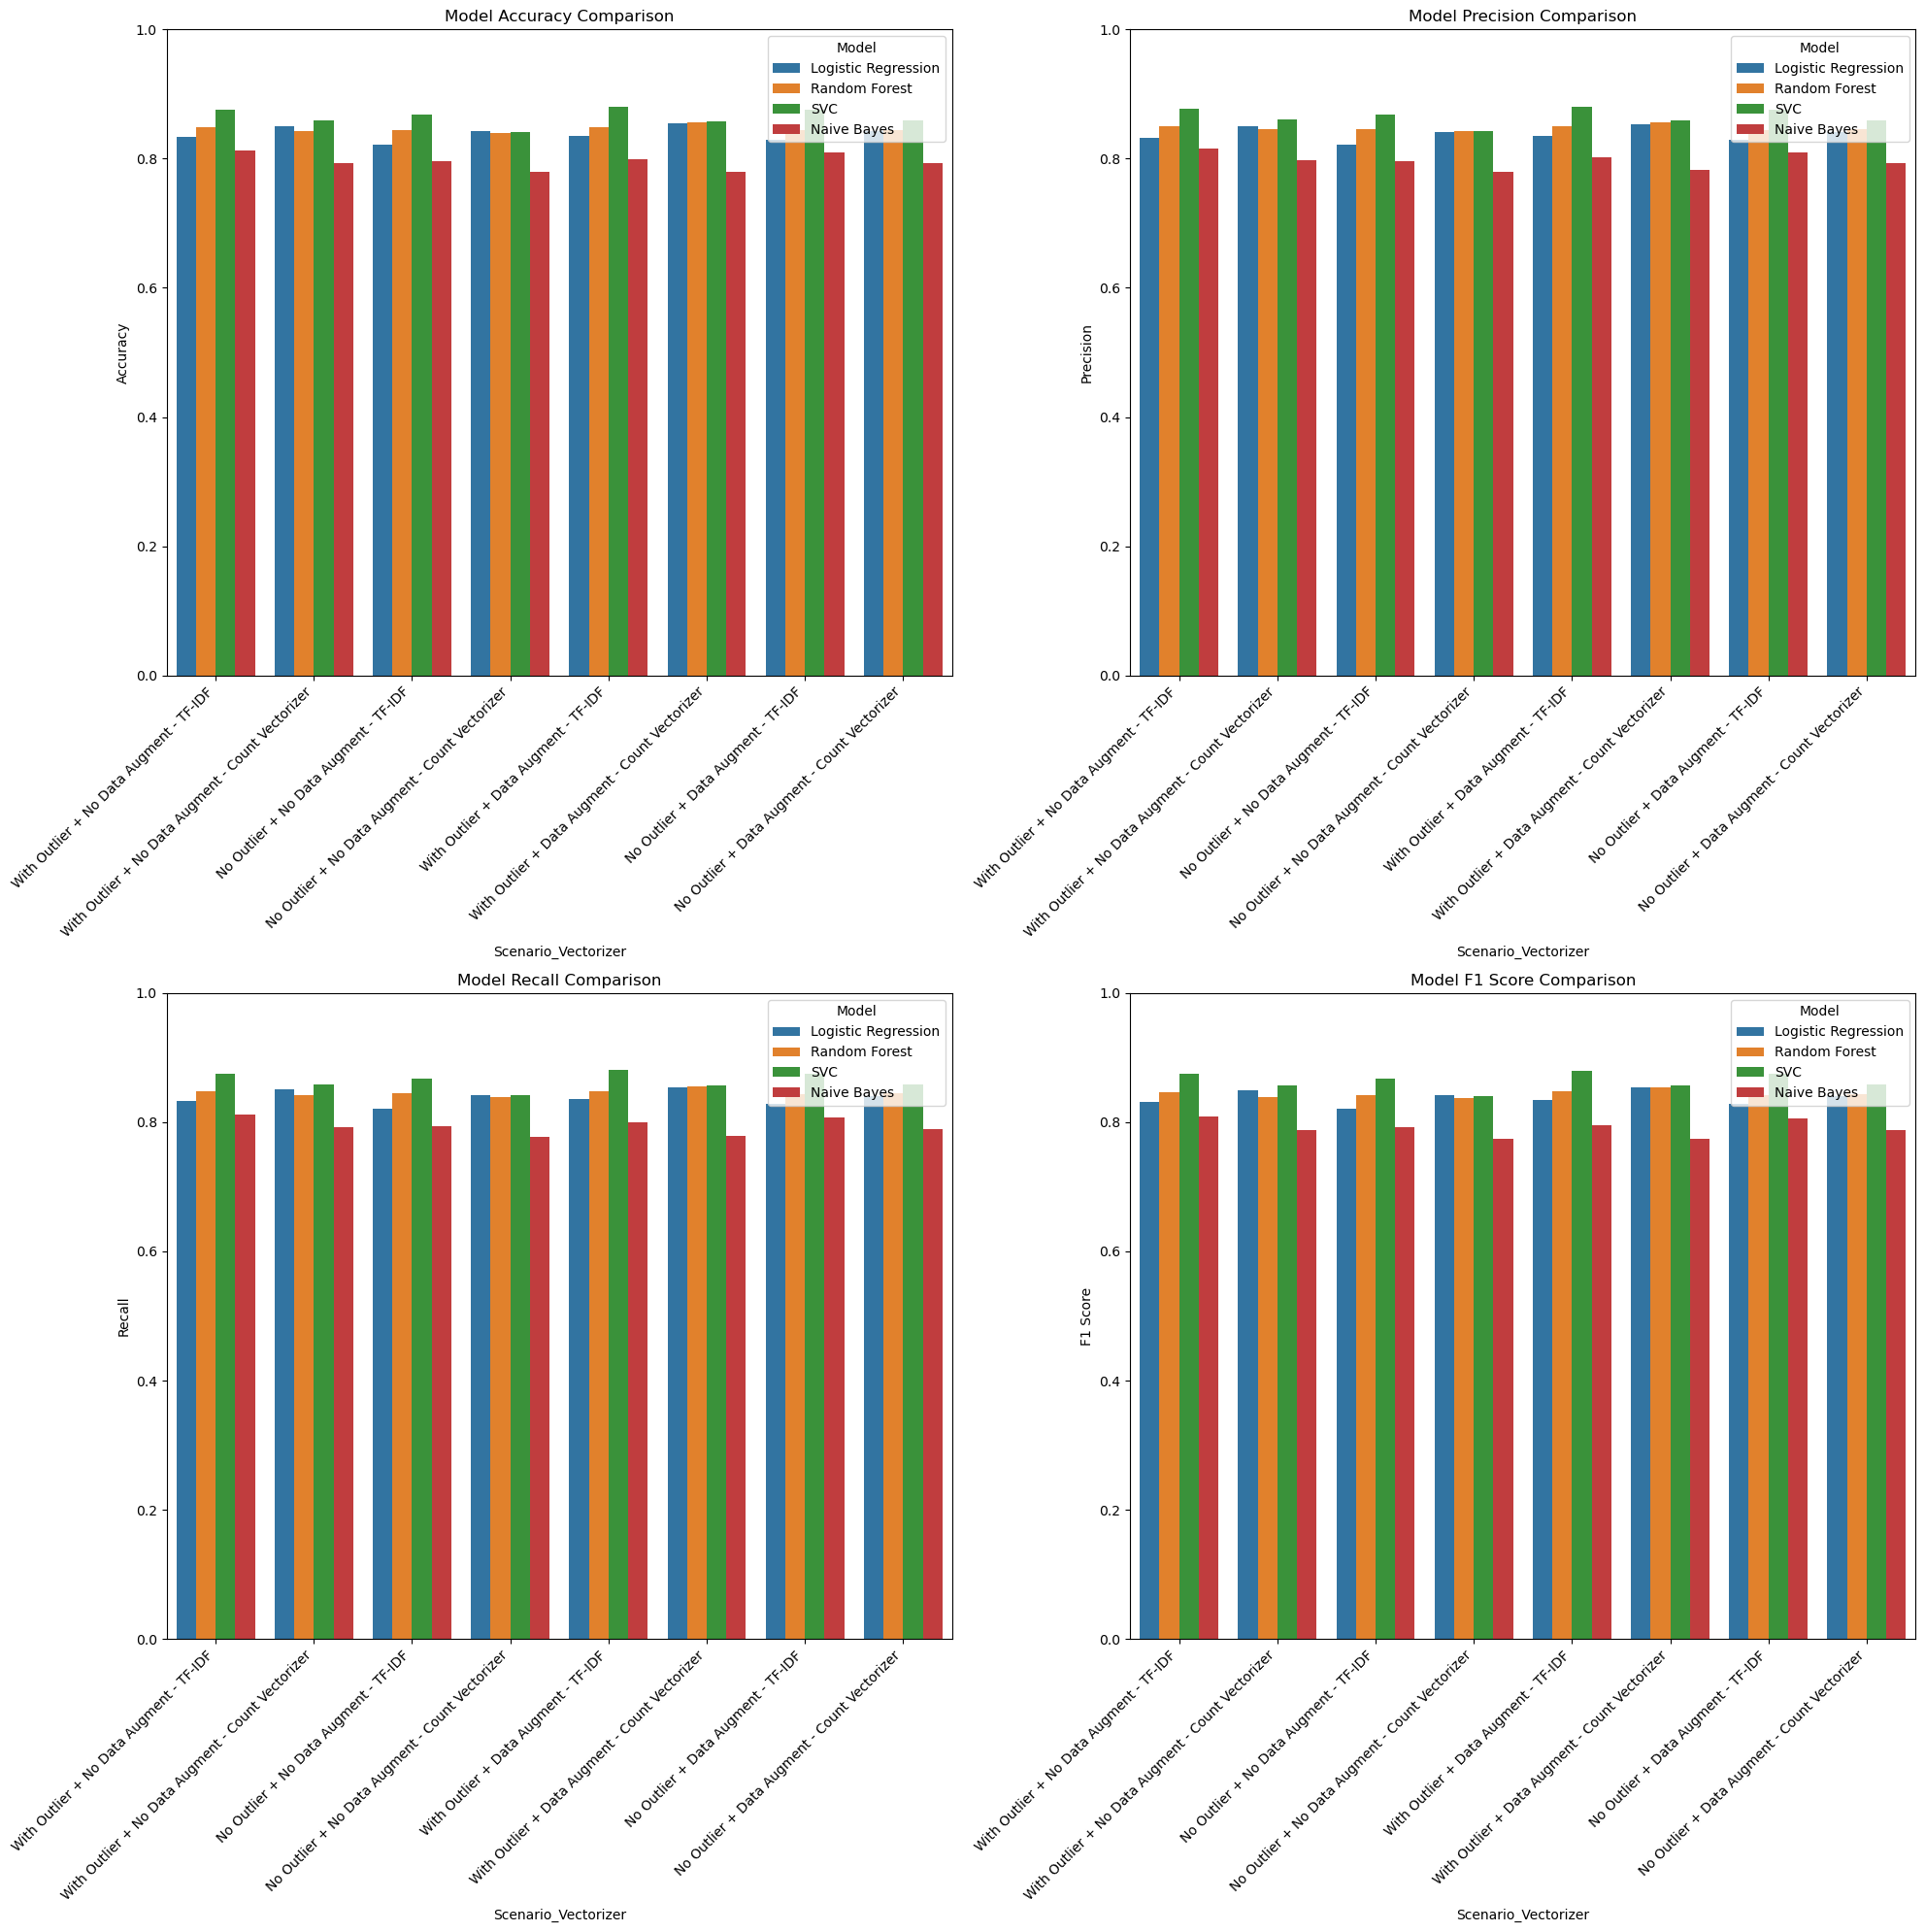

In [121]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Membuat kolom baru 'Scenario_Vectorizer'
results_df['Scenario_Vectorizer'] = results_df['Scenario'] + ' - ' + results_df['Vectorizer']


# Set up the matplotlib figure
plt.figure(figsize=(20, 20))

# List of metrics to plot
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Loop through each metric and create a subplot
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    sns.barplot(data=results_df, x='Scenario_Vectorizer', y=metric, hue='Model')
    plt.title(f'Model {metric} Comparison')
    plt.ylim(0, 1)
    plt.ylabel(metric)
    plt.xlabel('Scenario_Vectorizer')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.tight_layout()
plt.show()


In [122]:
# Tampilkan report
results_df

,Scenario,Model,Accuracy,Precision,Recall,F1 Score,Vectorizer,Scenario_Vectorizer
0,With Outlier + No Data Augment,Logistic Regression,0.833912,0.832808,0.833359,0.832014,TF-IDF,With Outlier + No Data Augment - TF-IDF
1,With Outlier + No Data Augment,Random Forest,0.848380,0.849780,0.847709,0.846459,TF-IDF,With Outlier + No Data Augment - TF-IDF
2,With Outlier + No Data Augment,SVC,0.876157,0.877241,0.875625,0.875004,TF-IDF,With Outlier + No Data Augment - TF-IDF
3,With Outlier + No Data Augment,Naive Bayes,0.813079,0.816031,0.812412,0.809271,TF-IDF,With Outlier + No Data Augment - TF-IDF
4,With Outlier + No Data Augment,Logistic Regression,0.850694,0.849510,0.850386,0.849722,Count Vectorizer,With Outlier + No Data Augment - Count Vectorizer
5,With Outlier + No Data Augment,Random Forest,0.842014,0.845126,0.841251,0.839640,Count Vectorizer,With Outlier + No Data Augment - Count Vectorizer
6,With Outlier + No Data Augment,SVC,0.858796,0.860550,0.858144,0.857166,Count Vectorizer,With Outlier + No Data Augment - Count Vectorizer
7,With Outlier + No Data Augment,Naive Bayes,0.793403,0.798101,0.792494,0.787669,Count Vectorizer,With Outlier + No Data Augment - Count Vectorizer
8,No Outlier + No Data Augment,Logistic Regression,0.822209,0.821186,0.821587,0.820791,TF-IDF,No Outlier + No Data Augment - TF-IDF
9,No Outlier + No Data Augment,Random Forest,0.844654,0.845435,0.844347,0.842585,TF-IDF,No Outlier + No Data Augment - TF-IDF


## 7. Pencarian Model Terbaik

Setelah melakukan evaluasi terhadap berbagai model, model dengan performa terbaik berdasarkan F1 Score telah ditemukan. Berikut adalah rincian model tersebut:

- **Model**: [Nama Model]
- **Skenario**: [Skenario]
- **Vektorizer**: [Tipe Vektorizer]
- **Akurasi**: [Akurasi]
- **Presisi**: [Presisi]
- **Recall**: [Recall]
- **F1 Score**: [F1 Score]

### Kesimpulan
- Jika F1 Score >= 0.8:
  - Model menunjukkan performa yang sangat baik, mengindikasikan kemampuan prediksi yang kuat.
- Jika F1 Score >= 0.6:
  - Model menunjukkan performa yang moderat, dengan potensi untuk perbaikan.
- Jika F1 Score < 0.6:
  - Performa model berada di bawah ekspektasi, menunjukkan bahwa optimasi lebih lanjut atau pra-pemrosesan data mungkin diperlukan.


In [123]:
# Find the best performing model based on a chosen metric (e.g., F1 Score)
best_model = results_df.loc[results_df['F1 Score'].idxmax()]

# Print the best performing model and its details
print("\nBest Performing Model:")
print(f"Model: {best_model['Model']}")
print(f"Scenario: {best_model['Scenario']}")
print(f"Vectorizer: {best_model['Vectorizer']}")
print(f"Accuracy: {best_model['Accuracy']:.4f}")
print(f"Precision: {best_model['Precision']:.4f}")
print(f"Recall: {best_model['Recall']:.4f}")
print(f"F1 Score: {best_model['F1 Score']:.4f}")

# General conclusion
print("\nConclusion:")
if best_model['F1 Score'] >= 0.8:
    print("The model performed exceptionally well, indicating a strong predictive capability.")
elif best_model['F1 Score'] >= 0.6:
    print("The model performed moderately well, indicating potential for improvement.")
else:
    print("The model's performance is below expectations, suggesting that further optimization or data preprocessing may be required.")



Best Performing Model:
Model: SVC
Scenario: With Outlier + Data Augment
Vectorizer: TF-IDF
Accuracy: 0.8808
Precision: 0.8806
Recall: 0.8804
F1 Score: 0.8802

Conclusion:
The model performed exceptionally well, indicating a strong predictive capability.


## Model Terbaik

- **Model**: SVC
- **Skenario**: Dengan Outlier + Data Augment
- **Vektorisasi**: TF-IDF
- **Akurasi**: 0.8808
- **Presisi**: 0.8806
- **Recall**: 0.8804
- **F1 Score**: 0.8802

## Kesimpulan

Model ini menunjukkan kinerja yang sangat baik, menunjukkan kemampuan prediksi yang kuat.
